In [1]:
import sklearn

#NN Surrogate model class
from injector_surrogate_quads import *

from emittance_calc import getNormEmit
from sampling_functions import getGroundTruth, getBeamsize

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

#BO
from bayes_opt import BayesianOptimization

# Load injector model

In [5]:
Model = Surrogate_NN()

Model.load_saved_model(model_path = '../models/', \
                       model_name = 'model_OTR2_NA_rms_emit_elu_2021-07-27T19_54_57-07_00')
Model.load_scaling()
Model.take_log_out = False

energy = 0.135 #GeV

# Set up sampling and objectives

In [6]:
#convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

In [7]:
ref_point = ref_point[0]

In [5]:
ref_point[15]#3,5,4 #quad 15

-3.218399988942528

In [8]:
#input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','SQ01:b1_gradient','CQ01:b1_gradient','QE04:b1_gradient']

#output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

def evaluate(varx,vary,varz,varscan=[-5,-4,-3,-2,-1,0]): 
    numscan = len(varscan)
    
    #make input array of length model_in_list (inputs model takes)
    x_in = np.empty((numscan,len(Model.model_in_list)))
    
    #fill in reference point around which to optimize
    for i in range(0,len(ref_point)):
        x_in[:,i]=ref_point[i] 

    #set solenoid, SQ, CQ to values from optimization step
    x_in[:, Model.loc_in[opt_var_names[0]]] = varx
    x_in[:, Model.loc_in[opt_var_names[1]]] = vary
    x_in[:, Model.loc_in[opt_var_names[2]]] = varz
    
    #set quad 525 to values for scan
    x_in[:, Model.loc_in[opt_var_names[3]]] = varscan

    #output predictions
    y_out = Model.pred_machine_units(x_in) 
    
    emitx = y_out[:,Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    emity = y_out[:,Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    sigma_y = y_out[:,Model.loc_out['sigma_y']] #grab norm_emit_y out of the model

    print(repr(varscan), repr(emity), repr(sigma_y))
    
    print(f"predicted normemitx {np.mean(emitx)/1e-6:.2f}, normemity {np.mean(emity)/1e-6:.2f}")
    #plt.plot(x_in[:,Model.loc_in['QE04:b1_gradient']],y_out[:,0], label="sig_x")
    #plt.plot(x_in[:,Model.loc_in['QE04:b1_gradient']],y_out[:,1], label="sig_y")
    
    x_rms = y_out[:,0]
    y_rms = y_out[:,1]

    norm_emit = getNormEmit(energy, varscan, x_rms, y_rms) #normalized emittance

    return  norm_emit/1e-6


In [18]:
np.array([-4,-2.5,-0.5])*0.1 # how bax is taking it?

array([-0.4 , -0.25, -0.05])

[-4, -2.5, -0.5] array([5.5994053e-07, 5.7491280e-07, 5.8234338e-07], dtype=float32) array([6.8509289e-05, 1.7536027e-04, 3.8779643e-04], dtype=float32)
predicted normemitx 0.56, normemity 0.57
scanned nemitx 1.07, scanned nemity 1.75


1.3683608713253457

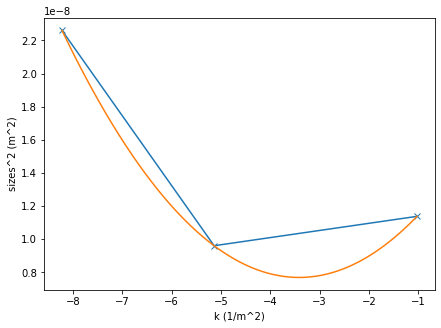

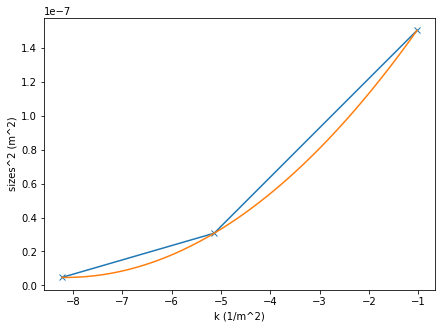

In [60]:
# around x focus
#evaluate(0.4657, -0.0071, -0.0169, [ -2, -1.5, -1, 0])
scan_val = np.linspace(-2.5,-0.5,10) # works ish
scan_val = np.linspace(-4.4,-2,10) # same
scan_val = [-4, -2.5, -0.5] # a bit worse in y axis


evaluate( 0.4779, -0.000687298, -0.001499227, scan_val)




array([-5.        , -4.44444444, -3.88888889, -3.33333333, -2.77777778,
       -2.22222222, -1.66666667, -1.11111111, -0.55555556,  0.        ]) array([5.5877354e-07, 5.5792350e-07, 5.6084775e-07, 5.6599902e-07,
       5.7189095e-07, 5.7759127e-07, 5.8140722e-07, 5.8280921e-07,
       5.8243921e-07, 5.8104735e-07], dtype=float32) array([7.2312730e-05, 5.1920149e-05, 7.4601179e-05, 1.1038701e-04,
       1.5241007e-04, 1.9938959e-04, 2.5158536e-04, 3.1163957e-04,
       3.8055429e-04, 4.5504363e-04], dtype=float32)
predicted normemitx 0.56, normemity 0.57
scanned nemitx 1.07, scanned nemity 1.04


1.0568644035215184

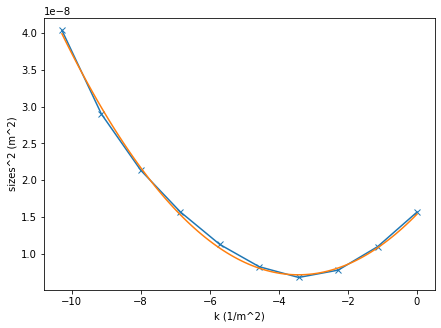

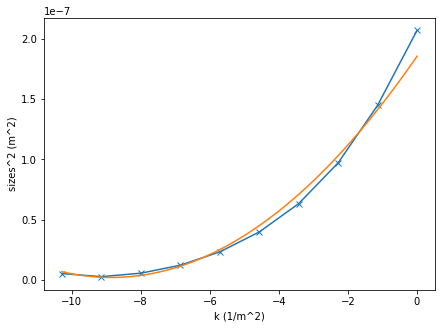

In [12]:
# around y focus
#evaluate(0.4657, -0.0071, -0.0169, [ -7, -6, -5.5, -5, -4, -3.5, -2])
scan_val = np.linspace(-5,0,10)
evaluate( 0.4779, -0.000687298, -0.001499227, scan_val)